In [2]:
%reload_ext autoreload
%autoreload 2
from qecdec import RotatedSurfaceCode_Memory
from qecdec import MWPMDecoder, BPDecoder, SlidingWindow_Decoder
from qecdec.utils import get_stats, bar_plot_stats, stacked_bar_plot_stats
import numpy as np

In [3]:
d = 5
rounds = 20
window_size = 5
commit_size = 1
bp_iters = 50
shots = 10_000
seed = 42
error_rates = [0.004, 0.006, 0.008, 0.01, 0.012]
gamma = np.load("gamma.npy")

In [4]:
results = {}

for p in error_rates:
    category = 'p={:.3f}'.format(p)
    print("Collecting data for {}".format(category))

    # Set up the experiment.
    expmt = RotatedSurfaceCode_Memory(
        d, rounds,
        basis='Z',
        data_qubit_error_rate=p,
        meas_error_rate=p,
    )

    # Sample data.
    sampler = expmt.circuit.compile_detector_sampler(seed=seed)
    syndromes, observables = sampler.sample(shots, separate_observables=True)

    # Set up the decoders.
    bp = BPDecoder(expmt.chkmat, expmt.prior, max_iter=bp_iters)
    mwpm = MWPMDecoder(expmt.chkmat, expmt.prior)
    sw = SlidingWindow_Decoder.from_pcm_prior(
        expmt.chkmat,
        expmt.prior,
        detectors_per_layer=expmt.num_detectors_per_layer,
        window_size=window_size,
        commit_size=commit_size
    )

    # Decode.
    print("Decoding with BP...")
    ehat_bp = bp.decode_batch(syndromes)
    print("Decoding with BP(SW)...")
    sw.configure_inner_decoders('BP', max_iter=bp_iters)
    ehat_bp_sw = sw.decode_batch(syndromes)
    print("Decoding with DMemBP(SW)...")
    sw.configure_inner_decoders('DMemBP', gamma=gamma, max_iter=bp_iters)
    ehat_dmembp_sw = sw.decode_batch(syndromes)
    print("Decoding with MWPM...")
    ehat_mwpm = mwpm.decode_batch(syndromes)
    print("Decoding with MWPM(SW)...")
    sw.configure_inner_decoders('MWPM')
    ehat_mwpm_sw = sw.decode_batch(syndromes)

    # Get stats and store results.
    print("Getting stats...")
    results[category] = {
        'BP': get_stats(expmt.chkmat, expmt.obsmat, syndromes, observables, ehat_bp),
        'BP(SW)': get_stats(expmt.chkmat, expmt.obsmat, syndromes, observables, ehat_bp_sw),
        'DMemBP(SW)': get_stats(expmt.chkmat, expmt.obsmat, syndromes, observables, ehat_dmembp_sw),
        'MWPM': get_stats(expmt.chkmat, expmt.obsmat, syndromes, observables, ehat_mwpm),
        'MWPM(SW)': get_stats(expmt.chkmat, expmt.obsmat, syndromes, observables, ehat_mwpm_sw),
    }
    print("-" * 100)

print("Data collection complete!")

Decoding with BP...
Decoding with BP(SW)...
Decoding with DMemBP(SW)...
Decoding with MWPM...
Decoding with MWPM(SW)...
Getting stats...
----------------------------------------------------------------------------------------------------
Decoding with BP...
Decoding with BP(SW)...
Decoding with DMemBP(SW)...
Decoding with MWPM...
Decoding with MWPM(SW)...
Getting stats...
----------------------------------------------------------------------------------------------------
Decoding with BP...
Decoding with BP(SW)...
Decoding with DMemBP(SW)...
Decoding with MWPM...
Decoding with MWPM(SW)...
Getting stats...
----------------------------------------------------------------------------------------------------
Decoding with BP...
Decoding with BP(SW)...
Decoding with DMemBP(SW)...
Decoding with MWPM...
Decoding with MWPM(SW)...
Getting stats...
----------------------------------------------------------------------------------------------------
Decoding with BP...
Decoding with BP(SW)...
Deco

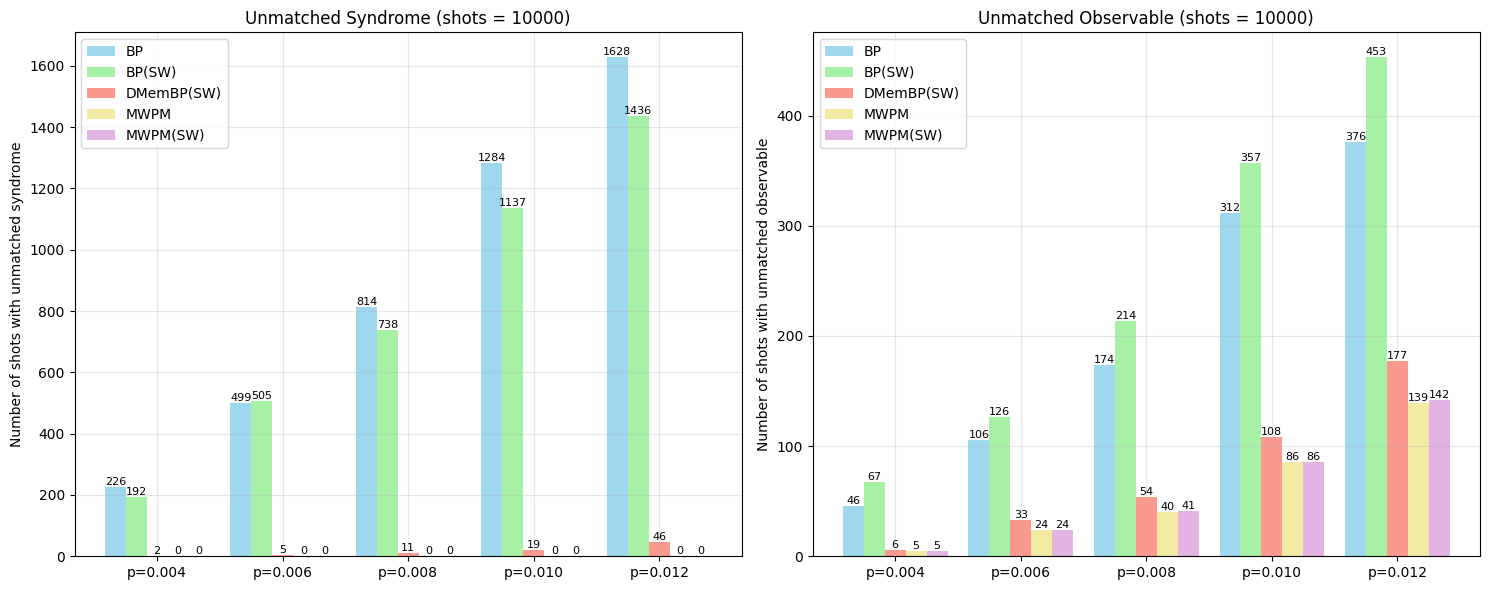

In [5]:
bar_plot_stats(results)

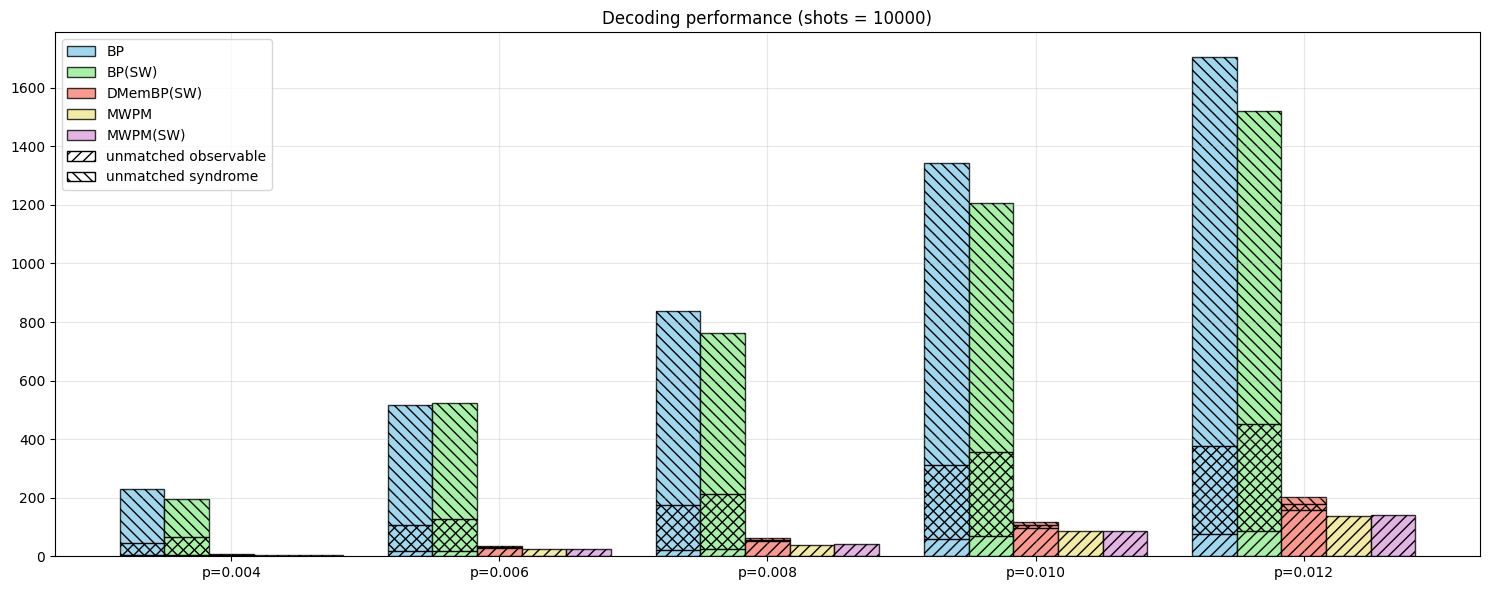

In [6]:
stacked_bar_plot_stats(results)